In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd

In [5]:
header = ['userId', 'movieId', 'rating', 'timestamp']
ratings = pd.read_csv('./ml-100k/u.data', sep='\t', names=header)
ratings.head(10)

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


In [6]:
u_unique = ratings.userId.unique()
user2Idx = {o:i+1 for i,o in enumerate(u_unique)}

m_unique = ratings.movieId.unique()
movie2Idx = {o:i+1 for i,o in enumerate(m_unique)}

In [7]:
# Ver parte de los diccionarios
print(dict(list(user2Idx.items())[0:10]))
print(dict(list(movie2Idx.items())[0:10]))

{196: 1, 186: 2, 22: 3, 244: 4, 166: 5, 298: 6, 115: 7, 253: 8, 305: 9, 6: 10}
{242: 1, 302: 2, 377: 3, 51: 4, 346: 5, 474: 6, 265: 7, 465: 8, 451: 9, 86: 10}


In [8]:
ratings.userId = ratings.userId.apply(lambda x: user2Idx[x])
ratings.movieId = ratings.movieId.apply(lambda x: movie2Idx[x])

In [9]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,3,881250949
1,2,2,3,891717742
2,3,3,1,878887116
3,4,4,2,880606923
4,5,5,1,886397596


In [10]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_val = train_test_split(ratings, test_size=0.2)

In [11]:
n_split = 20000
ratings_train = ratings[n_split:]
ratings_val = ratings[:n_split]
len(ratings_train), len(ratings_val)

(80000, 20000)

In [12]:
ratings_train.head()

,userId,movieId,rating,timestamp
20000,392,13,2,877399864
20001,457,882,4,886365297
20002,111,61,4,875306477
20003,176,1315,2,874951695
20004,122,658,4,877879172


In [13]:
n_users = int(ratings.userId.nunique())
n_movies = int(ratings.movieId.nunique())
n_users_train = int(ratings_train.userId.nunique())
n_movies_train = int(ratings_train.movieId.nunique())
print(n_users, n_movies, n_users_train, n_movies_train)

943 1682 943 1650


In [14]:
# Por el embedding que arranca en 1
ratings_train['userId'].max(), ratings_train['movieId'].max()

(943, 1682)

In [15]:
from keras.layers import Embedding, Input, Flatten, Dot
from keras.regularizers import l2
from keras import Model
from keras.constraints import non_neg

2023-08-24 14:59:54.955694: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
n_latent_factors = 20

In [17]:
movie_input = Input(shape=[1], name='Item')
# movie_embedding = Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_embedding = Embedding(n_movies + 1, n_latent_factors, embeddings_regularizer=l2(0.001),
                            name='Movie-Embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

user_input = Input(shape=[1],name='User')
user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))
#user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, 
#                                                  n_latent_factors,name='User-Embedding', embeddings_constraint=non_neg())(user_input))

In [18]:
prod = Dot(axes=1, name='DotProduct')([movie_vec, user_vec])
model = Model([user_input, movie_input], prod)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Item (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 User (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 Movie-Embedding (Embedding  (None, 1, 20)                33660     ['Item[0][0]']                
 )                                                                                                
                                                                                                  
 User-Embedding (Embedding)  (None, 1, 20)                18880     ['User[0][0]']            

In [19]:
from keras.optimizers import Adam

In [21]:
from fnn_helper import PlotLosses
plot_losses = PlotLosses(1, None)

In [22]:
import keras.backend as K 
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [24]:
model.compile(Adam(learning_rate=0.001), 'mean_squared_error', metrics=[root_mean_squared_error])

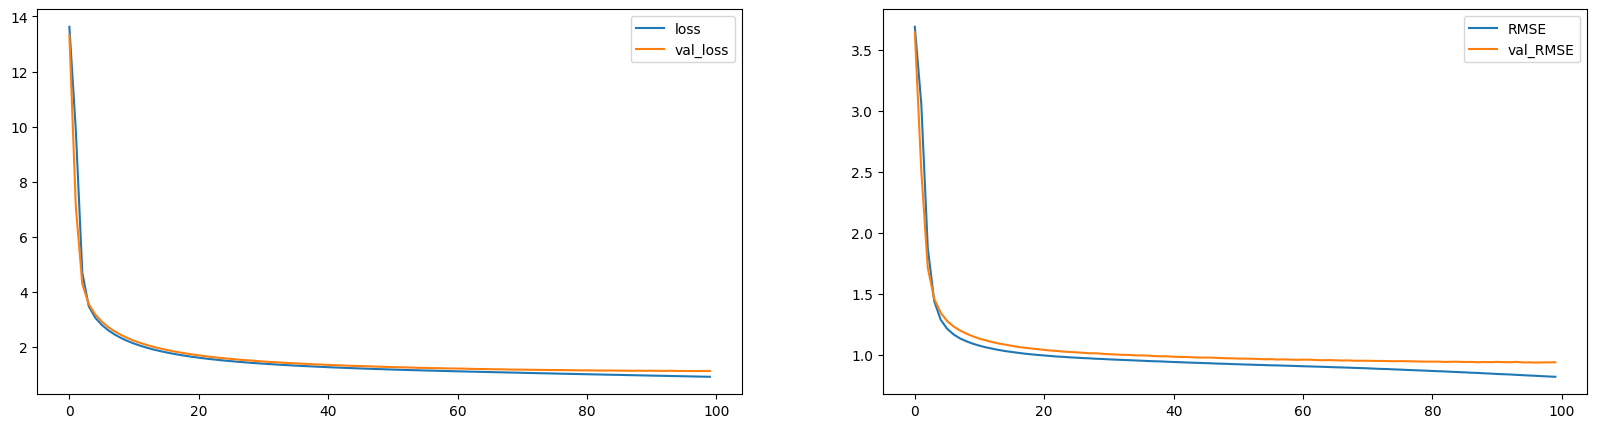

250/250 [==============================] - 1s 3ms/step - loss: 0.9243 - root_mean_squared_error: 0.8220 - val_loss: 1.1352 - val_root_mean_squared_error: 0.9411


In [25]:
history = model.fit([ratings_train.userId, ratings_train.movieId], 
                    ratings_train.rating, 
                    batch_size=320,
                    validation_data=([ratings_val.userId, ratings_val.movieId], ratings_val.rating), 
                    epochs=100, 
                    callbacks = [plot_losses],
                    verbose=1)

In [26]:
model.metrics_names

['loss', 'root_mean_squared_error']

In [27]:
model.evaluate([ratings_val.userId, ratings_val.movieId], ratings_val.rating)

625/625 [==============================] - 1s 1ms/step - loss: 1.1352 - root_mean_squared_error: 0.9333


[1.1352169513702393, 0.9332678914070129]

In [28]:
model.evaluate([ratings_train.userId, ratings_train.movieId], ratings_train.rating)

2500/2500 [==============================] - 2s 844us/step - loss: 0.8941 - root_mean_squared_error: 0.7974


[0.8940964937210083, 0.7974344491958618]